In [48]:
import pandas as pd
from os import listdir
import matplotlib.pyplot as plt
import numpy as np

In [49]:
def read_slopes(filename):
    df = pd.read_csv(
        filename,
        sep='\t',
        header=None,
        names=['time', 'date', 'barcode', 'temp', 'curr_low', 'curr_high', 't_wait', 't_sample', 'slope', 'status', 'flow', 'flow2']
    )
    df = df.filter(['barcode', 'flow', 'slope'])
    return df

In [50]:
barcodes_bad_data = [
    104051,
    703491,
    703480,
    703492,
    703493,
    105767,
    105760,
    105762,
    105756,
    105217,
    115074,
    115075,
    115076,
    105218,
    115078,
    105189,
    115084
]

In [58]:
flow_percentage = 100*100/200

errors_default = []
errors_prediction = []

data_folder = './old_calib_all_raw_data'
for filename in listdir(data_folder):
    df = read_slopes(data_folder + '/' + filename)
    barcodes = set(df['barcode'])
    for b in barcodes:
        if b in barcodes_bad_data:
            continue
        
        df_sel = df[df.barcode == b]
        flows = list(df_sel['flow'])
        slopes = list(df_sel['slope'])
        
        flow_limit_temp = flow_percentage/100.0*max(flows)
        flow_limit, slope_limit = min( zip(flows, slopes), key=lambda fs:abs(fs[0]-flow_limit_temp)) # Take closest flow
        
        flows_filtered = []
        slopes_filtered = []
        for f, s in zip(flows, slopes):
            if f <= flow_limit:
                flows_filtered.append(f)
                slopes_filtered.append(s)
        
        params = np.polynomial.polynomial.polyfit(slopes_filtered, flows_filtered, 4)
        
        # Select point with max flow and evaluate
        flow0, slope0 = min( zip(flows, slopes), key=lambda fs: abs(fs[0]-max(flows)) )
        x = slope0
        flow_prediction1 = np.dot(params, [1, x, x**2, x**3, x**4])
        
        params_derivative = [params[1], 2*params[2], 3*params[3], 4*params[4]]
        x = slope_limit
        df_ds = np.dot(params_derivative, [1, x, x**2, x**3])
        
        flow_prediction2 = flow_limit + df_ds*(slope0 - slope_limit)
        
        if flow_limit < flow0: # Check that limit flow is not equal to max flow
            errors_default.append(100*(flow_prediction1-flow0)/flow0)
            errors_prediction.append(100*(flow_prediction2-flow0)/flow0)
        # print(f'Ratio={flow_limit/flow0:.2f}, Flow={flow0}, naive={flow_prediction1:.2f}, , prediction={flow_prediction2:.2f}')

# plt.title(f'Relative prediction error (%) for flow 50% too high')
# plt.grid()
# plt.boxplot([errors_default, errors_prediction], widths=0.4, labels=['Default', 'Linear extrapolation'])
        

/home/pieter/.local/lib/python3.10/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/home/pieter/.local/lib/python3.10/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/home/pieter/.local/lib/python3.10/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/home/pieter/.local/lib/python3.10/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/home/pieter/.local/lib/python3.10/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)
/home/pieter/.local/lib/python3.10/site-packages/numpy/

In [59]:
# errors_prediction_10 = errors_prediction
# errors_prediction_30 = errors_prediction
# errors_prediction_50 = errors_prediction
# errors_prediction_100 = errors_prediction

Text(0, 0.5, 'Prediction error (%)')

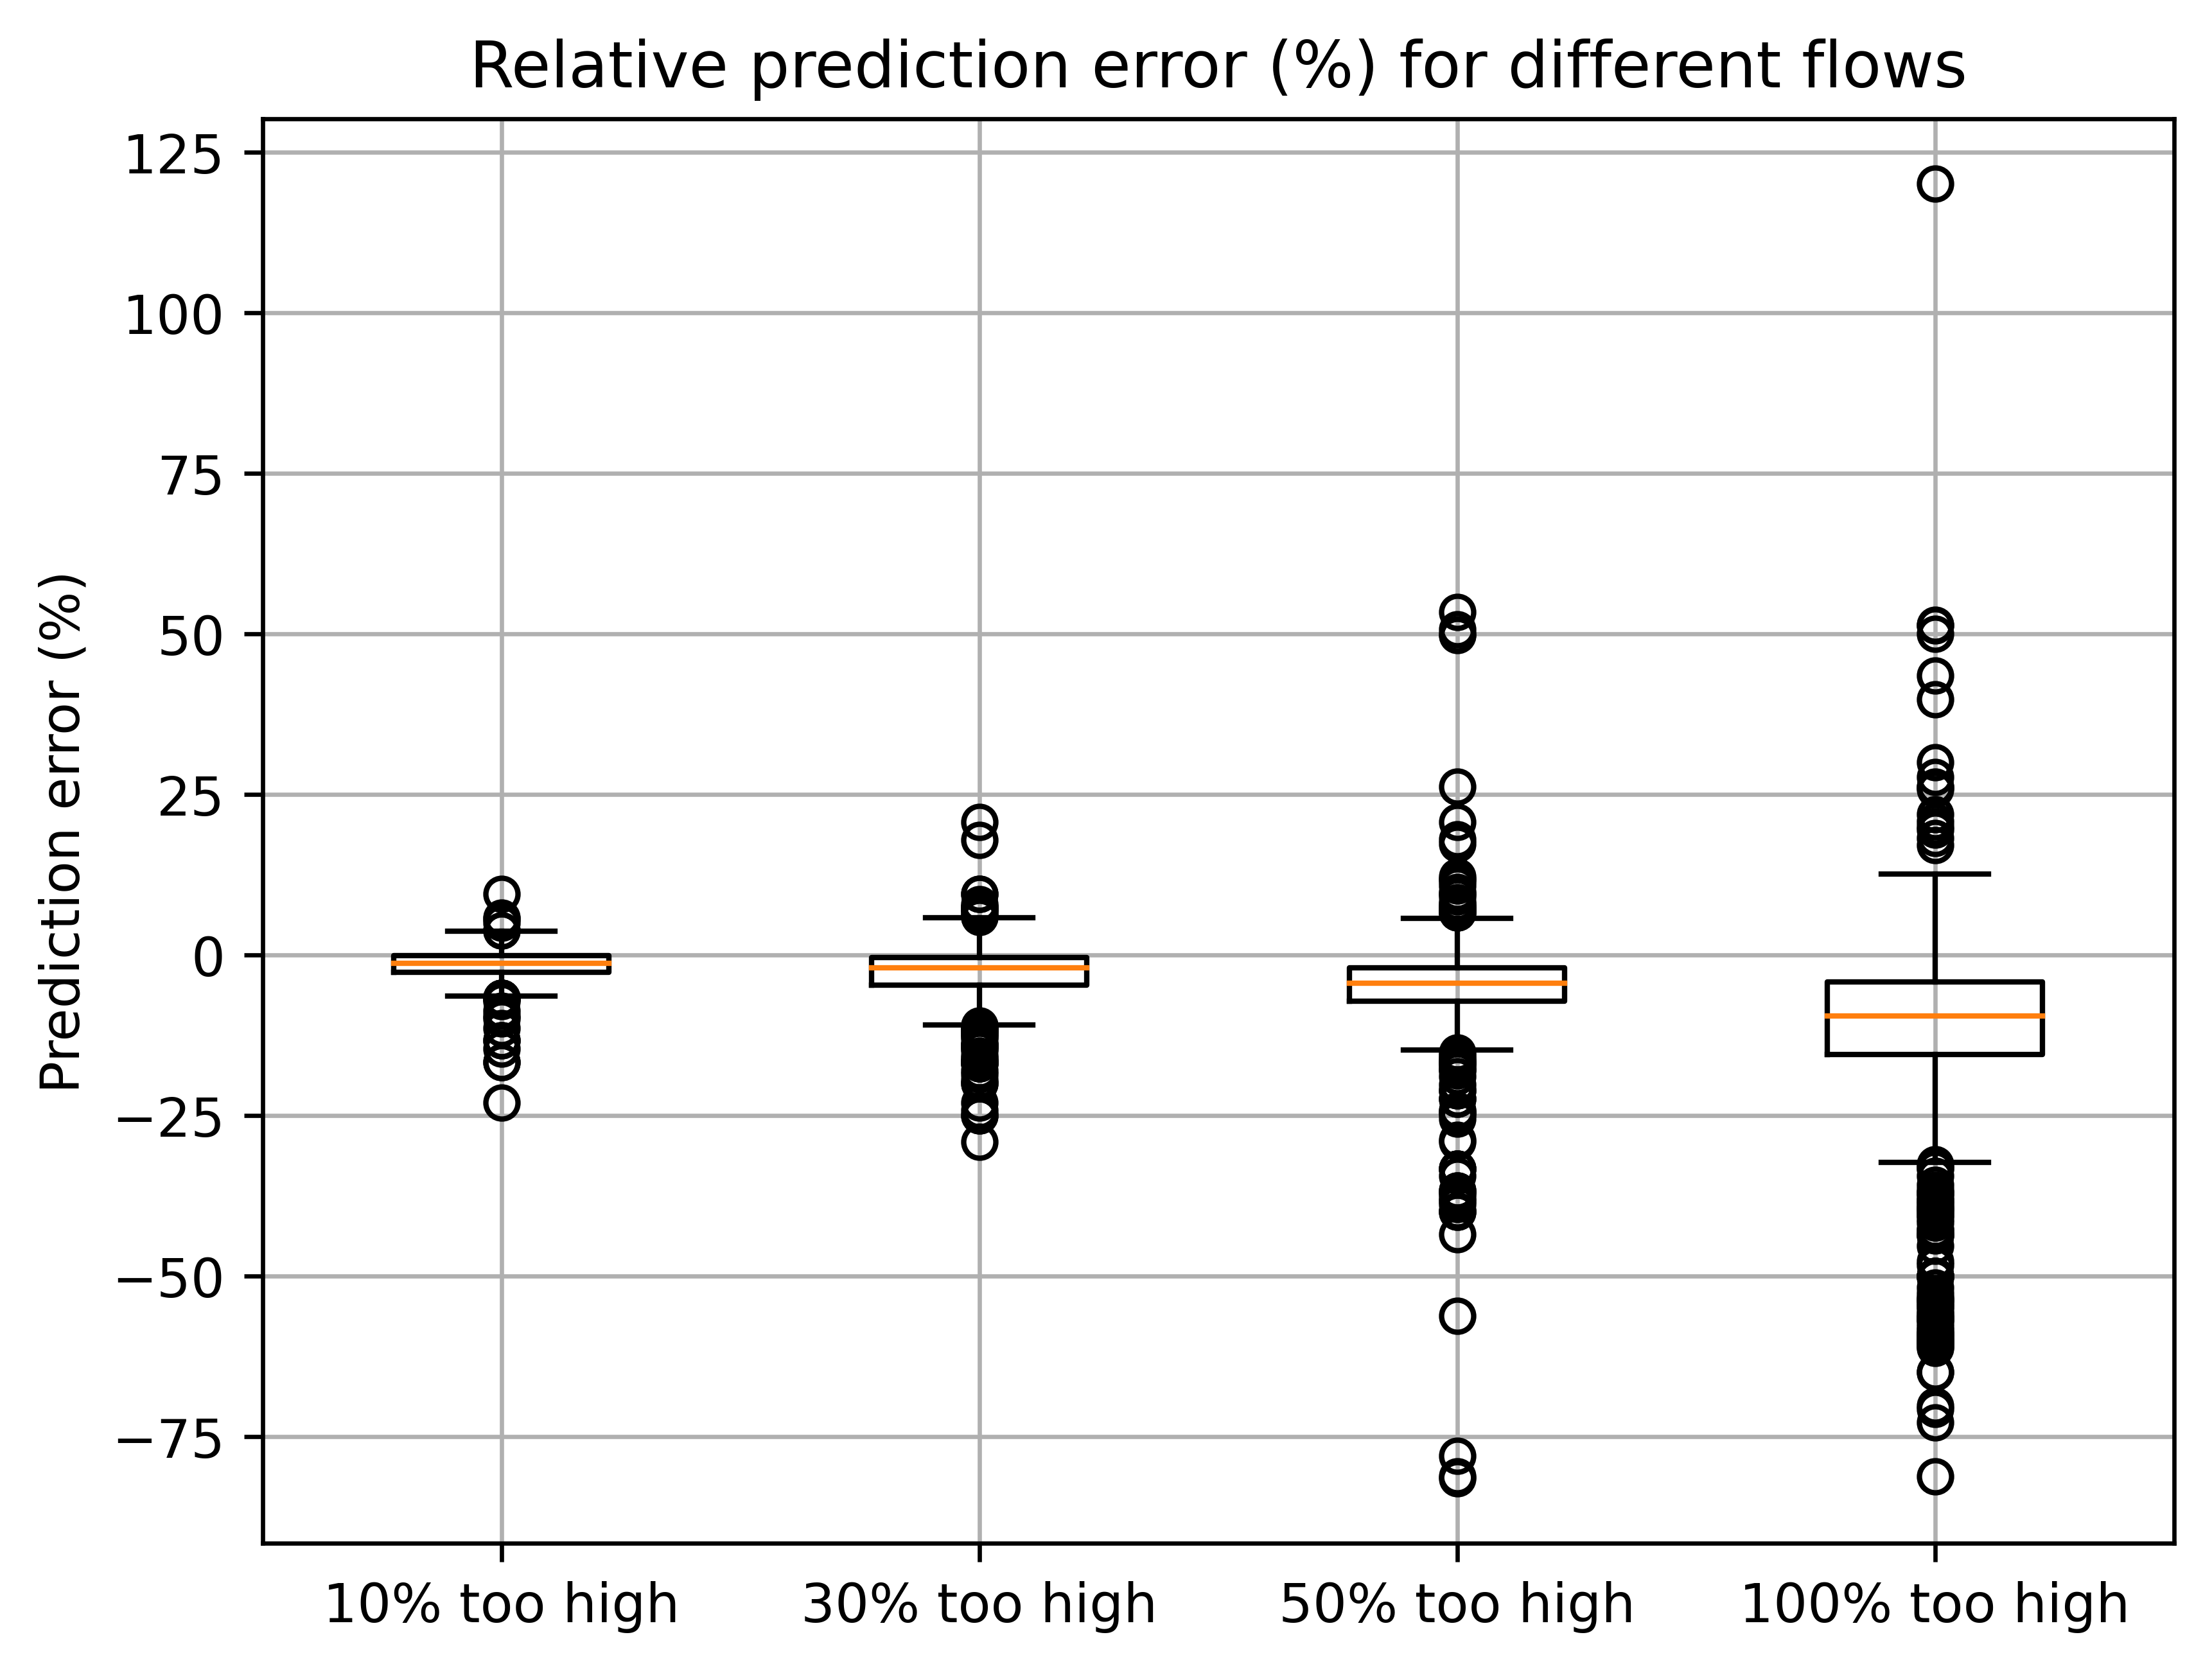

In [66]:
plt.rcParams['figure.dpi'] = 600

plt.boxplot([errors_prediction_10, errors_prediction_30, errors_prediction_50, errors_prediction_100], labels=['10% too high', '30% too high', '50% too high', '100% too high'])
plt.grid()
plt.title('Relative prediction error (%) for different flows')
plt.ylabel('Prediction error (%)')